Chuẩn bị dữ liệu

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Tạo SparkSession
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Đọc dữ liệu
data = spark.read.csv("comments2.csv", header=True, inferSchema=True)

# Hiển thị thông tin dữ liệu
data.printSchema()
data.show(5)

# Loại bỏ giá trị NULL trong cột comment_text
data = data.filter(col("comment_text").isNotNull())

root
 |-- video_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- published_at: string (nullable = true)
 |-- like_count: string (nullable = true)

+-----------+------------------+--------------------+--------------------+----------+
|   video_id|            author|        comment_text|        published_at|like_count|
+-----------+------------------+--------------------+--------------------+----------+
|N-gpD9QqTK0|    @truchothi7758|Sau khi dc xem vi...|2024-12-10T15:26:42Z|         0|
|N-gpD9QqTK0|     @ÁiNguyễn-b1p|Cảm ơn khoai.tất ...|2024-12-10T15:15:36Z|         0|
|N-gpD9QqTK0| @UyenNguyen-lu5bu|Thích tập này quá...|2024-12-10T14:42:05Z|         0|
|N-gpD9QqTK0|@dieunguyeninh3741|Xem video của Kho...|2024-12-10T14:33:42Z|         0|
|N-gpD9QqTK0|  @huynhthuytram24|Một video thực sự...|2024-12-10T13:54:28Z|         0|
+-----------+------------------+--------------------+--------------------+----------+
only showing

Tiền xử lí

In [2]:
# Lọc các hàng có video_id không hợp lệ
data = data.filter(col("video_id").rlike("^[a-zA-Z0-9_-]{11}$"))
data.select("video_id").distinct().show(truncate=False)

+-----------+
|video_id   |
+-----------+
|aoFeasRsiyk|
|oL9OX4e2Kl4|
|NTEgu8uWS1I|
|M_WD9Dxayk8|
|IJ24VtLd1jU|
|N-gpD9QqTK0|
|NgaZHtCr_a0|
|92-IbWKp_3k|
|cJD4fc5l3fM|
|mzeh6lWhFi4|
|0Q8fkicguR8|
|MLBhMV8k6e0|
|5cW2Kj4_7HY|
|7TdSEX4JFdw|
|xEnYZ55FCG8|
|E-JMv4ebt18|
|7v7EBziokmM|
|FDMDKktG75I|
|rMBaVOW4AE8|
|5AJd2FJUVkc|
+-----------+
only showing top 20 rows



In [3]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

# Tokenizer: tách từ
tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")
data = tokenizer.transform(data)

# Loại bỏ từ dừng
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
data = stopwords_remover.transform(data)

# HashingTF: Tạo vector từ văn bản
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=1000)
data = hashing_tf.transform(data)

# IDF: Chuẩn hóa vector
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(data)
data = idf_model.transform(data)

data.select("comment_text", "filtered_words", "features").show(5)


+--------------------+--------------------+--------------------+
|        comment_text|      filtered_words|            features|
+--------------------+--------------------+--------------------+
|Sau khi dc xem vi...|[sau, khi, dc, xe...|(1000,[28,34,72,7...|
|Cảm ơn khoai.tất ...|[cảm, ơn, khoai.t...|(1000,[92,153,177...|
|Thích tập này quá...|[thích, tập, này,...|(1000,[61,244,376...|
|Xem video của Kho...|[xem, video, của,...|(1000,[34,92,317,...|
|Một video thực sự...|[một, video, thực...|(1000,[28,67,76,9...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



Huấn luyện mô hình

In [4]:
from pyspark.sql.functions import when

data = data.withColumn(
    "label",
    when(col("comment_text").rlike("cảm ơn|tuyệt vời|yêu thích|hay|xuất sắc|đỉnh cao|tốt nhất|dễ thương|tuyệt|ý nghĩa|ấm áp|cười|chúc mừng|👍|❤️|🥰|❤|😊|Xúc động|<3|🎁|🎈|🎉|😍|😘"), 2)  # Tích cực
    .when(col("comment_text").rlike("ổn|bình thường|cũng được|ok|tạm ổn"), 1)  # Trung lập
    .when(col("comment_text").rlike("tệ|kém|không thích|chán|thất vọng|quá tệ|dở|kém chất lượng|dở tệ|qc|quảng cáo"), 0)  # Tiêu cực
    .otherwise(1)  # Gán mặc định là trung lập nếu không khớp
)
data.select("comment_text", "label").show(10)

+--------------------+-----+
|        comment_text|label|
+--------------------+-----+
|Sau khi dc xem vi...|    2|
|Cảm ơn khoai.tất ...|    2|
|Thích tập này quá...|    2|
|Xem video của Kho...|    2|
|Một video thực sự...|    2|
|Anh Khoai dễ thươ...|    2|
|Cảm ơn vì những g...|    2|
|người ta ổ chuột ...|    1|
|em theo dõi hành ...|    1|
|        QC nhiều quá|    1|
+--------------------+-----+
only showing top 10 rows



In [5]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Thay các giá trị không hợp lệ trong cột like_count bằng 0
data = data.withColumn(
    "like_count", 
    when(col("like_count").cast("int").isNotNull(), col("like_count").cast("int")).otherwise(0)
)

# Kết hợp features và like_count
assembler = VectorAssembler(inputCols=["features", "like_count"], outputCol="final_features")
data = assembler.transform(data)

# Chia tập dữ liệu thành train và test
train, test = data.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression
lr = LogisticRegression(featuresCol="final_features", labelCol="label")
model = lr.fit(train)

# Dự đoán trên tập test
predictions = model.transform(test)
predictions.select("comment_text", "label", "prediction").show(10)

# Đánh giá mô hình
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Độ chính xác: {accuracy}")

+--------------------+-----+----------+
|        comment_text|label|prediction|
+--------------------+-----+----------+
|Xa xôi vậy mà BYD...|    1|       1.0|
|Khoai đi nhớ có t...|    1|       2.0|
|Thú vị thiệt luôn...|    1|       1.0|
|"DUNG TU "" MOI N...|    1|       1.0|
|Chúc anh Khoai th...|    1|       1.0|
|không mấy ngày an...|    1|       1.0|
|Mất tích cả tháng...|    1|       1.0|
|Hời ơi ổng đăng v...|    2|       1.0|
|nhìn anh Phương d...|    1|       2.0|
|Hải quan VN mình ...|    1|       1.0|
+--------------------+-----+----------+
only showing top 10 rows

Độ chính xác: 0.8194665686394641


In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType

# Tạo SparkSession
spark = SparkSession.builder \
    .appName("Video Analysis") \
    .getOrCreate()


# Định nghĩa schema mới
video_schema = StructType([
    StructField("Video ID", StringType(), True),
    StructField("Title", StringType(), True),
    StructField("Category_ID", IntegerType(), True),
    StructField("Published At", TimestampType(), True),
    StructField("Channel Title", StringType(), True),
    StructField("View Count", IntegerType(), True),
    StructField("Like Count", IntegerType(), True),
    StructField("Comment Count", IntegerType(), True),
])

# Đọc file CSV với schema mới
file_path = "video.csv"
df = spark.read.option("header", "true").schema(video_schema).csv(file_path)

# Kiểm tra schema và hiển thị dữ liệu
df.show()


+-----------+--------------------+-----------+-------------------+----------------+----------+----------+-------------+
|   Video ID|               Title|Category_ID|       Published At|   Channel Title|View Count|Like Count|Comment Count|
+-----------+--------------------+-----------+-------------------+----------------+----------+----------+-------------+
|N-gpD9QqTK0|Nấu đám tiệc kiểu...|         19|2024-12-01 17:44:37|Khoai Lang Thang|   1520244|     37496|         1969|
|M_WD9Dxayk8|Đến nhà người lạ ...|         19|2024-11-17 18:57:32|Khoai Lang Thang|   1602732|     28690|         1378|
|5AJd2FJUVkc|Ăn 10 món lạ ở kh...|         19|2024-11-05 20:27:52|Khoai Lang Thang|   2130532|     29506|         1236|
|92-IbWKp_3k|Gặp nạn ở CHỢ TRỜ...|         19|2024-10-27 18:52:00|Khoai Lang Thang|   1779109|     24698|         1794|
|MLBhMV8k6e0|Du lịch ẩm thực C...|         19|2024-10-16 21:05:48|Khoai Lang Thang|   2031031|     28867|         1248|
|cJD4fc5l3fM|Châu Phi p8: HÀNG...|      

In [7]:

predictions = predictions.join(df, predictions["video_id"] == df["Video ID"], "left_outer")


Phân tích xu hướng bình luận trên video

In [8]:
from pyspark.sql.functions import count, mean

# Tính số lượng và tỷ lệ cảm xúc trên mỗi video
video_sentiment = predictions.groupBy("video_id","Title", "prediction").agg(count("prediction").alias("count"))
video_sentiment = video_sentiment.groupBy("video_id","Title").pivot("prediction").sum("count").fillna(0)
columns = video_sentiment.columns
# Đổi tên cột cảm xúc
#video_sentiment = video_sentiment.withColumnRenamed( "0","negative")\
#                                 .withColumnRenamed("1","neutral")\
#                                 .withColumnRenamed( "2","positive")
new_columns = ['negative' if col == '0.0' else 'neutral' if col == '1.0' else 'positive' if col == '2.0' else col for col in columns]
video_sentiment = video_sentiment.toDF(*new_columns)
# Hiển thị kết quả
video_sentiment.show()

+-----------+--------------------+--------+-------+--------+
|   video_id|               Title|negative|neutral|positive|
+-----------+--------------------+--------+-------+--------+
|M_WD9Dxayk8|Đến nhà người lạ ...|       2|    183|      87|
|IHNKnPgbBGM|🇮🇳Ấn Độ: Cả ngà...|       0|    107|      50|
|Kp27BlfAl3Y|Mùa sầu riêng ở M...|       3|    293|      70|
|MLBhMV8k6e0|Du lịch ẩm thực C...|       2|    178|      43|
|fCbjgpgXa4A|Vừa bước vô chợ p...|       0|    150|      31|
|tce4fo144HA|🇹🇭No nê ở chợ đ...|       0|     93|      25|
|7brb9WzD1YE|Cuộc sống miệt vư...|       3|    247|      68|
|Psj74U61H1Y|"🇯🇵Nhật Bản #1:...|       0|    129|      35|
|OexdHszpU00|🇰🇷Ký sự du lịch...|       0|    120|      29|
|i7J4C8LHE6Y| Bắc Hà Du Ký Phần 3|       0|    134|      36|
|Qyh8ZArkHMs|🇰🇷Trai Miền Tây...|       0|    123|      36|
|7v7EBziokmM|Du lịch Mỹ tự túc...|       0|    117|      40|
|V_2_CPiTDR4|Nấu tiệc Miền Tây...|       0|    291|     191|
|rcgrVgVlV5c|🇯🇵Ẩm thực ở Tok...|  

In [9]:
from pyspark.sql.functions import col

# Tính tổng số bình luận cho mỗi video
video_sentiment = video_sentiment.withColumn("total_comments", 
                                            col("negative") + col("neutral") + col("positive"))

# Tính tỷ lệ cảm xúc
video_sentiment = video_sentiment.withColumn("negative_ratio", col("negative") / col("total_comments"))\
                                 .withColumn("neutral_ratio", col("neutral") / col("total_comments"))\
                                 .withColumn("positive_ratio", col("positive") / col("total_comments"))

# Hiển thị kết quả
video_sentiment.select("video_id", "Title","negative_ratio", "neutral_ratio", "positive_ratio").show()


+-----------+--------------------+--------------------+------------------+-------------------+
|   video_id|               Title|      negative_ratio|     neutral_ratio|     positive_ratio|
+-----------+--------------------+--------------------+------------------+-------------------+
|M_WD9Dxayk8|Đến nhà người lạ ...|0.007352941176470588|0.6727941176470589|0.31985294117647056|
|IHNKnPgbBGM|🇮🇳Ấn Độ: Cả ngà...|                 0.0|0.6815286624203821| 0.3184713375796178|
|Kp27BlfAl3Y|Mùa sầu riêng ở M...| 0.00819672131147541|0.8005464480874317| 0.1912568306010929|
|MLBhMV8k6e0|Du lịch ẩm thực C...|0.008968609865470852|0.7982062780269058|0.19282511210762332|
|fCbjgpgXa4A|Vừa bước vô chợ p...|                 0.0|0.8287292817679558| 0.1712707182320442|
|tce4fo144HA|🇹🇭No nê ở chợ đ...|                 0.0| 0.788135593220339|  0.211864406779661|
|7brb9WzD1YE|Cuộc sống miệt vư...|0.009433962264150943|0.7767295597484277| 0.2138364779874214|
|Psj74U61H1Y|"🇯🇵Nhật Bản #1:...|                 0.0|0

In [10]:
# Tính tổng số cảm xúc cho mỗi loại
video_sentiment_agg = video_sentiment.select("negative", "neutral", "positive").agg(
    {"negative": "sum", "neutral": "sum", "positive": "sum"}
)

# Hiển thị tổng số cảm xúc cho từng loại
video_sentiment_agg.show()


+-------------+------------+-------------+
|sum(negative)|sum(neutral)|sum(positive)|
+-------------+------------+-------------+
|          121|       18102|         6260|
+-------------+------------+-------------+



In [11]:
# Lọc các video có tỷ lệ cảm xúc tiêu cực lớn
negative_videos = video_sentiment.filter(col("negative_ratio") > 0.5)  # Ví dụ, tỷ lệ tiêu cực > 50%
negative_videos.show()


+--------+-----+--------+-------+--------+--------------+--------------+-------------+--------------+
|video_id|Title|negative|neutral|positive|total_comments|negative_ratio|neutral_ratio|positive_ratio|
+--------+-----+--------+-------+--------+--------------+--------------+-------------+--------------+
+--------+-----+--------+-------+--------+--------------+--------------+-------------+--------------+



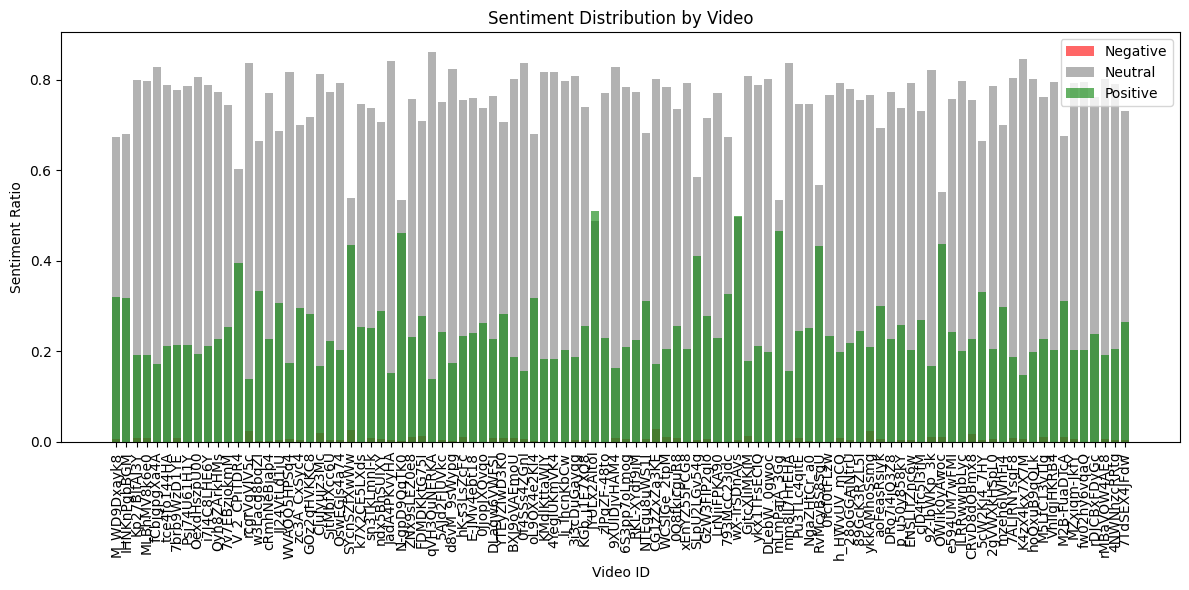

In [12]:
import matplotlib.pyplot as plt

# Chuyển dữ liệu sang Pandas DataFrame
pd_data = video_sentiment.select("video_id", "negative_ratio", "neutral_ratio", "positive_ratio").toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.bar(pd_data["video_id"], pd_data["negative_ratio"], label="Negative", color="red", alpha=0.6)
plt.bar(pd_data["video_id"], pd_data["neutral_ratio"], label="Neutral", color="gray", alpha=0.6)
plt.bar(pd_data["video_id"], pd_data["positive_ratio"], label="Positive", color="green", alpha=0.6)

plt.title("Sentiment Distribution by Video")
plt.xlabel("Video ID")
plt.ylabel("Sentiment Ratio")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()
